# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from gammapy.modeling.models import PointSpatialModel
from gammapy.modeling.models import SkyModel, Models
from gammapy.astro.darkmatter.utils import SigmaVEstimator, DMDatasetOnOff
from gammapy.spectrum import CountsSpectrum
from gammapy.astro.darkmatter import DarkMatterAnnihilationSpectralModel
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 100 * u.h # in hours
offset = 0.5 * u.deg
FOVLON=0 * u.deg
FOVLAT=0 * u.deg

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 0

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



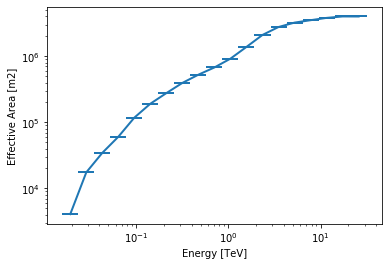

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

In [5]:
#edisp = cta_irf["edisp"].to_energy_dispersion(
#    offset=offset, e_true=energy_true, e_reco=energy
#)
#edisp.plot_matrix()
#print(edisp.data)

## Build the background counts from PSF and IRF background

In [6]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [7]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=FOVLON, fov_lat=FOVLAT, energy_reco=energy
)
bkg = CountsSpectrum(
    energy[:-1],
    energy[1:],
    data=(bkg_data * solid_angles).to_value("h-1")*livetime
)

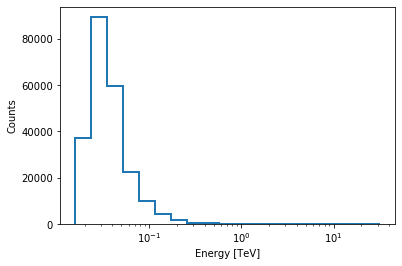

In [8]:
bkg.plot_hist()

## Simulate OnOff observation with DM emission model

In [9]:
# DM Spatial Component
spatial_model = PointSpatialModel(
    lon_0="0 deg", lat_0="0 deg", frame="icrs"
)

In [10]:
# DM Flux
spectral_model = DarkMatterAnnihilationSpectralModel(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [11]:
#from gammapy.modeling.models import Absorption, AbsorbedSpectralModel
#absorption_model = Absorption.read_builtin('dominguez')
#spectral_model = AbsorbedSpectralModel(spectral_model, absorption_model, redshift)

In [12]:
sky_model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)
models = Models([sky_model])

In [13]:
dataset = DMDatasetOnOff(
    aeff=aeff,
    models=models,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5
)

In [14]:
nuisance = dict(
    j=JFAC,
    jobs=JFAC,
    sigmaj=0.1*JFAC,
    sigmatau=0.01,
    # width=5 # default value / optional param 
)
dataset.nuisance = nuisance

## The SigmaVEstimator

**Enable inspection**

In [15]:
import logging
logging.basicConfig()
#logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("WARNING")
logging.getLogger("gammapy.astro.darkmatter.utils").setLevel("DEBUG")

**Instatiate estimator**

In [16]:
masses = [100, 200, 500, 1000, 5000, 10000, 50000]*u.GeV
channels = ["b", "tau", "Z"] 
estimator = SigmaVEstimator(dataset, masses, channels, background_model=bkg)

**Run estimator and fetch results**

In [17]:
%%time
# stat_profile_opts=dict(bounds=(-25, 100), nvalues=125)   # optional param
# stat_profile_opts = dict(bounds=5, nvalues=50)           # default values
# if nuisance = True the process takes the nuisance parameters into account
result = estimator.run(runs=3, nuisance=True)

INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 0
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.0328 	| LZero: 111.441 	| LMin:  111.408
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 0.0567 	| LMax: 111.497 	| LMin:  111.441
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: b
INFO:gammapy.astro.darkmatter.utils:Mass: 100.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: 0.2279 	| LZero: 114.186 	| LMin:  113.958
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 582.0896 	| LMax: 696.048 	| LMin:  113.958
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 8.864 	| SvBest: 8.864 	| SvUL: 117.444
DEBUG:gammapy.astro.darkmatter.utils:JBest: 5.073052212128796e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:3.5233282487778054e-24 cm3 / s
INFO:gammapy.astro

DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: -0.992 	| SvBest: 0.000 	| SvUL: 13.079
DEBUG:gammapy.astro.darkmatter.utils:JBest: 4.645639658753934e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:3.923702587046315e-25 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: tau
INFO:gammapy.astro.darkmatter.utils:Mass: 50000.0 GeV
DEBUG:gammapy.astro.darkmatter.utils:ZeroDeltaL: -0.1074 	| LZero: 113.892 	| LMin:  114.000
DEBUG:gammapy.astro.darkmatter.utils:MaximumDeltaL: 243.8021 	| LMax: 357.802 	| LMin:  114.000
DEBUG:gammapy.astro.darkmatter.utils:SvBestFound: 9.116 	| SvBest: 9.116 	| SvUL: 107.633
DEBUG:gammapy.astro.darkmatter.utils:JBest: 3.6959613844942275e+19 GeV2 / cm5
INFO:gammapy.astro.darkmatter.utils:Sigma v:3.228990559346278e-24 cm3 / s
INFO:gammapy.astro.darkmatter.utils:----
INFO:gammapy.astro.darkmatter.utils:Run: 1
INFO:gammapy.astro.darkmatter.utils:Channel: Z
INFO:gamma

CPU times: user 44.3 s, sys: 366 ms, total: 44.7 s
Wall time: 44.9 s


**Display results for channel b and run 1**

In [18]:
cols = ["mass", "sigma_v", "sv_ul", "sv_best", "j_best"]
result["runs"]["b"][1][cols]

mass,sigma_v,sv_ul,sv_best,j_best
GeV,cm3 / s,,,GeV2 / cm5
float64,float64,float64,float64,float64
100.0,3.5233282487778054e-24,117.44427495926017,8.86368258448486,5.073052212128796e+19
200.0,1.925449523569344e-24,64.18165078564479,4.152810570918321,3.397201689854685e+19
500.0,7.14591843710875e-25,23.819728123695832,0.0,2.7300099099068817e+19
1000.0,4.102293116302004e-25,13.674310387673346,0.0,3.3783676290021302e+19
5000.0,7.640902444177905e-25,25.469674813926346,0.0,3.430536149465616e+19
10000.0,1.2036916378661937e-24,40.123054595539784,0.6848053957898574,2.4163234980393443e+19
50000.0,2.2780951838173078e-24,75.93650612724359,0.0,3.3364200977405546e+19


**Plot likelihood profile for a specific fit**

In [19]:
idx = np.argwhere(masses.value==100)
profile = result["runs"]["Z"][0]["statprofile"][idx][0][0]

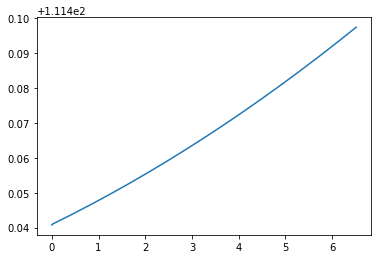

In [20]:
plt.plot(profile["values"], profile["stat"]);

## Obtained results

In [21]:
result["mean"]["b"]

mass,sigma_v,sigma_v_std,jfactor,jfactor_std
GeV,cm3 / s,cm3 / s,GeV2 / cm5,GeV2 / cm5
float64,float64,float64,float64,float64
100.0,3.5233282487778054e-24,0.0,3.41387851756701e+19,1.6591736945617859e+19
200.0,1.925449523569344e-24,0.0,3.397201689854685e+19,0.0
500.0,7.14591843710875e-25,0.0,2.7300099099068817e+19,0.0
1000.0,4.102293116302004e-25,0.0,3.3783676290021302e+19,0.0
5000.0,7.640902444177905e-25,0.0,3.430536149465616e+19,0.0
10000.0,1.2036916378661937e-24,0.0,2.4163234980393443e+19,0.0
50000.0,2.2780951838173078e-24,0.0,3.3364200977405546e+19,0.0


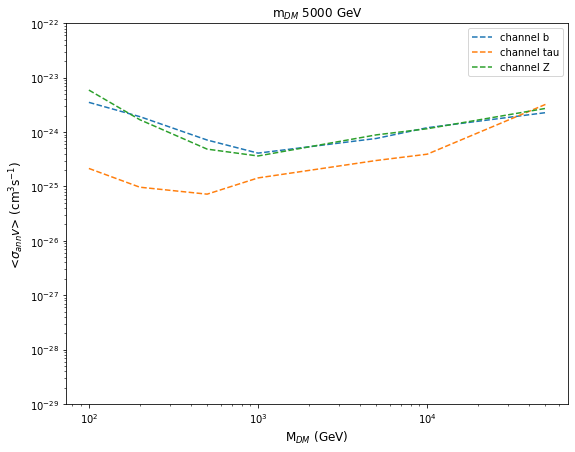

In [22]:
plt.figure(figsize=(9,7))
plt.ylim(1e-29, 1e-22)
plt.ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
plt.xlabel("M$_{DM}$ (GeV)", fontsize=12)
plt.title('m$_{DM}$ 5000 GeV')

for ch in channels:
    plt.loglog(
        result["mean"][ch]["mass"].data,
        result["mean"][ch]["sigma_v"].data,
        ls="--",
        label='channel {}'.format(ch)
       )
plt.legend();